In [1]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [2]:
gdrive_dir = 'gdrive/My Drive/Colab'
!rm -rf modis_utils
!git clone https://github.com/lamductan/modis_utils.git

Cloning into 'modis_utils'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 564 (delta 45), reused 52 (delta 23), pack-reused 483
Receiving objects: 100% (564/564), 137.53 KiB | 3.20 MiB/s, done.
Resolving deltas: 100% (369/369), done.


In [3]:
!pip install rasterio

In [0]:
import os
from scipy import misc
from matplotlib import pyplot as plt
from shutil import make_archive, unpack_archive, copy

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import LearningRateScheduler, CSVLogger

from modis_utils.misc import restore_data
from modis_utils.model.loss_function import PSNRLoss, lossSSIM, SSIM, step_decay
from modis_utils.model.loss_function import mse_with_mask_tf, mse_with_mask_tf_1, mse_with_mask

In [0]:
if not os.path.exists('data_file'):
    unpack_archive(os.path.join(gdrive_dir, 'data_file.zip'), '.')
if not os.path.exists('masked_data'):
    unpack_archive(os.path.join(gdrive_dir, 'masked_data.zip'), '.')
if not os.path.exists('preprocessed_data'):
    unpack_archive(os.path.join(gdrive_dir, 'preprocessed_data.zip'), '.')
if not os.path.exists('data_augment_merged'):
    unpack_archive(os.path.join(gdrive_dir, 'data_augment_merged.zip'), '.')

# Parameters

In [0]:
config_path = 'config.dat'
config_params = restore_data(os.path.join(gdrive_dir, config_path))

In [0]:
lr = config_params['lr']

In [0]:
training = True
crop_size = config_params['crop_size']
input_timesteps = config_params['input_timesteps']
output_timesteps = config_params['output_timesteps']
batch_size = config_params['batch_size']
compile_params = config_params['compile_params']
model_name = config_params['model_name']
preprocessed_type = config_params['preprocessed_type']
modis_product = config_params['modis_product']
monitor = config_params['monitor']
monitor_mode = config_params['monitor_mode']
resize_input = config_params['resize_input']

raw_data_dir = config_params['raw_data_dir']
reservoir_index = config_params['reservoir_index']
used_band = config_params['used_band']
year_range = config_params['year_range']
model_keras = config_params['model_keras']
original_batch_size = config_params['original_batch_size']

colab = True
TPU_FLAG = True

epochs = 20

In [17]:
try:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print('Use TPU')
    print(TPU_WORKER)
    TPU_FLAG = True
except:
    TPU_FLAG = False
    TPU_WORKER = None
    print('Use GPU')

Use TPU
grpc://10.106.249.138:8470


# End Parameters

In [0]:
from modis_utils.modis_utils import ModisUtils

In [0]:
modis_utils = ModisUtils(
    raw_data_dir=raw_data_dir,
    modis_product=modis_product,
    reservoir_index=reservoir_index,
    preprocessed_type=preprocessed_type,
    used_band=used_band,
    crop_size=crop_size,
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    year_range=year_range,
    model_name=model_name,
    batch_size=batch_size,
    model_keras=model_keras,
    compile_params=compile_params,
    original_batch_size=original_batch_size,
    TPU_FLAG=TPU_FLAG,
    training=training,
    monitor=monitor,
    monitor_mode=monitor_mode,
    resize_input=resize_input)

In [12]:
modis_utils._num_training_samples

12288

In [13]:
model = modis_utils.create_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [14]:
modis_utils.summary_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (None, 12, 32, 32, 1)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 12, 32, 32, 128)   594944    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 12, 32, 32, 128)   512       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 12, 32, 32, 128)   1180160   
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 12, 32, 32, 128)   512       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 12, 32, 32, 128)   1180160   
_________________________________________________________________
batch_normalization_v1_2 (Ba (None, 12, 32, 32, 128)   512       
__________

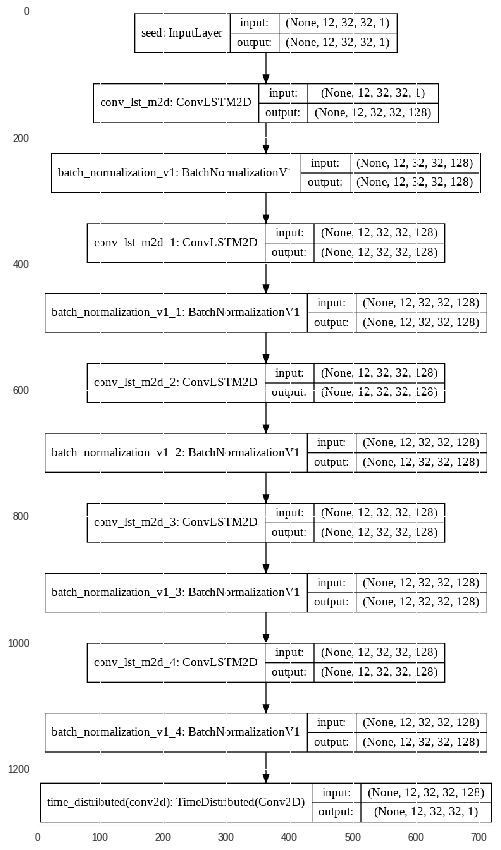

In [15]:
modis_utils.plot_model()

In [0]:
modis_utils.train(epochs=epochs, TPU_WORKER=TPU_WORKER)

In [24]:
copy(modis_utils.model_path, gdrive_dir)

'gdrive/My Drive/Colab/weights-02.h5'